In [1]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np

from pymongo import MongoClient
import pymongo

In [2]:
# 使用GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
! nvidia-smi

Fri Jun 24 01:31:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   38C    P8    22W / 260W |   3450MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 28%   

# LDA

## 2014 brief paragraph

In [3]:
file_us = open("../LDA/segment/data/us_file_brief_paragraph_2014.txt", "r")
us_lines = file_us.readlines()

# file_us = open("../MUSE-main/data/us_file_brief_p_paragraph.txt", "r")
# us_lines = file_us.readlines()

In [4]:
us_desc = [i.replace(" \n","").split(" ") for i in us_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [5]:
id2word = corpora.Dictionary(us_desc)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(2803 unique tokens: ['base', 'categorize', 'client', 'cloud', 'comprise']...)


In [6]:
corpus = [id2word.doc2bow(text) for text in us_desc]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 3), (8, 1), (9, 1)]


+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [7]:
topic_num_list = np.arange(2, 26, 1)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
    print(topic_num)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


,topic_num,gensim_perplexity,perplexity
0,2,-6.432051,621.447538
1,3,-6.426651,618.100441
2,4,-6.421314,614.810524
3,5,-6.418976,613.374835
4,6,-6.416858,612.077090
5,7,-6.407205,606.196893
6,8,-6.405881,605.394738
7,9,-6.402678,603.459175
8,10,-6.395734,599.283300
9,11,-6.385250,593.032802


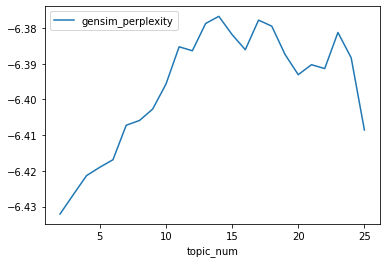

In [8]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-6.432051,621.447538
1,3,-6.426651,618.100441
2,4,-6.421314,614.810524
3,5,-6.418976,613.374835
4,6,-6.416858,612.077090
5,7,-6.407205,606.196893
6,8,-6.405881,605.394738
7,9,-6.402678,603.459175
8,10,-6.395734,599.283300
9,11,-6.385250,593.032802


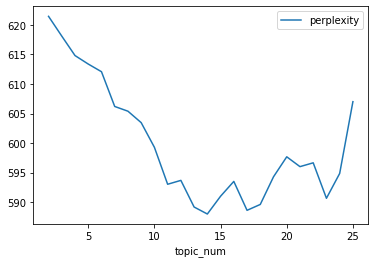

In [9]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

In [10]:
# 儲存LDA_result
result.to_csv("./result/LDA_us_brief_paragraph_2014.csv", index=False)

## priority description sentence

In [11]:
# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

In [12]:
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [13]:
# id2word = corpora.Dictionary(us_desc)
# print('資料集字典：')
# print(id2word)

In [14]:
# corpus = [id2word.doc2bow(text) for text in us_desc]
# print('第一篇文章 corpus :')
# print(corpus[0][:10])

+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [15]:
# topic_num_list = np.arange(2, 20, 2)
# result = []
# for topic_num in topic_num_list:
#     # perplexity
#     tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
#         corpus = corpus,
#         num_topics = topic_num ,
#         id2word=id2word,
#         random_state = 1500,
#         passes=5,
#         iterations=2000
#         )
#     tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
#     temp_skleran = np.exp(-1. * tmp_perplexity)
    
#     result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
#     print(topic_num)

In [16]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
# result

In [17]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='perplexity', label='perplexity')
# result

In [18]:
# 儲存LDA_result
# result.to_csv("./result/LDA_us_desc_p_s_2500.csv", index=False)

## 找出文章topic

In [19]:
best_num = result[result.perplexity == min(result.perplexity)]["topic_num"].values[0]

In [20]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = best_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )

In [21]:
# 取得每個文章的主題分佈
topics_doc = ldamodel.get_document_topics(corpus, minimum_probability=0.000001) 

In [22]:
c = [i[1] for i in topics_doc[0]]
c.index(max(c)) 

13

In [23]:
topics_us = [] 
for topics in topics_doc:
    c = [i[1] for i in topics]
    topics_us.append(c.index(max(c)))

In [24]:
topics_us

[13,
 1,
 4,
 1,
 9,
 2,
 13,
 4,
 7,
 3,
 4,
 11,
 9,
 4,
 7,
 4,
 3,
 9,
 10,
 1,
 7,
 9,
 4,
 4,
 12,
 13,
 4,
 12,
 4,
 7,
 1,
 7,
 13,
 4,
 12,
 12,
 6,
 7,
 9,
 1,
 4,
 4,
 8,
 5,
 3,
 5,
 4,
 4,
 4,
 2,
 11,
 8,
 2,
 1,
 9,
 12,
 4,
 8,
 9,
 12,
 7,
 3,
 4,
 11,
 3,
 4,
 4,
 4,
 3,
 13,
 4,
 4,
 3,
 12,
 9,
 7,
 2,
 3,
 3,
 3,
 4,
 7,
 13,
 12,
 12,
 13,
 1,
 7,
 4,
 1,
 1,
 10,
 7,
 4,
 7,
 8,
 4,
 4,
 2,
 4,
 7,
 4,
 5,
 13,
 10,
 8,
 2,
 13,
 2,
 12,
 2,
 9,
 5,
 7,
 12,
 12,
 12,
 4,
 0,
 12,
 5,
 12,
 1,
 10,
 7,
 10,
 5,
 4,
 3,
 12,
 4,
 11,
 4,
 0,
 12,
 7,
 7,
 7,
 7,
 2,
 4,
 8,
 12,
 8,
 10,
 8,
 3,
 2,
 13,
 7,
 0,
 2,
 9,
 3,
 1,
 2,
 10,
 1,
 1,
 2,
 3,
 4,
 2,
 7,
 13,
 9,
 13,
 12,
 12,
 4,
 7,
 11,
 6,
 9,
 1,
 0,
 9,
 4,
 12,
 4,
 9,
 8,
 12,
 8,
 13,
 7,
 13,
 2,
 12,
 10,
 0,
 11,
 1,
 7,
 12,
 5,
 4,
 12,
 1,
 1,
 10,
 9,
 4,
 10,
 10,
 12,
 9,
 13,
 0,
 9,
 3,
 1,
 10,
 7,
 1,
 10,
 13,
 4,
 1,
 6,
 2,
 8,
 10,
 11,
 9,
 5,
 2,
 9,
 10,
 3,
 10,
 3,
 4,
 4,

In [25]:
print(len(topics_us))
print(len(us_desc))

660
660


## 找出對應的patent編號和公司

In [26]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_us = db.rm_patent_us
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2014 = db.rm_patent_us_2014
    db_rm_us_2014 = db.rm_patent_us_2014
    # db_rm_de_2014 = db.rm_patent_de_2014
except errors.ConnectionFailure as err:
    print(err)

In [27]:
# data_us_desc = p_db_us.find({}, {"patentNumber":1, "brief": 1})
data_us_desc = db_rm_us_2014.find({}, {"patentNumber":1, "brief": 1, "current_assignee":1})

ls_id = []
ls_pNo = []
ls_com = []
ls_desc = []
for data in data_us_desc:
    # print(data["_id"],data["count"])
    ls_id.append(data["_id"])
    ls_pNo.append(data["patentNumber"])
    ls_com.append(data["current_assignee"])
    ls_desc.append(data["brief"])
    

In [28]:
# df_us = pd.DataFrame((zip(ls_id, ls_pNo, ls_desc)), columns = ['id', 'patentNumber', 'brief'])
df_us = pd.DataFrame((zip(ls_id, ls_pNo, ls_com, ls_desc)), columns = ['id', 'patentNumber', 'company', 'brief'])

In [29]:
df_us

,id,patentNumber,company,brief
0,62009ecc7b73c16636b310bc,US9253181B2,[Jiangsu Digital Dna Technology Co ltd],A new identification (ID) technology comprisin...
1,6200a0437b73c16636b310c8,US9338735B2,[Telefonaktiebolaget LM Ericsson AB],An extended cell search procedure enables more...
2,6200b1047b73c16636b310f6,US10122817B2,[Intel Corp],Embodiments provide a device profile mechanism...
3,6200b1b67b73c16636b31102,US9807687B2,[Qualcomm Inc],Techniques are provided to facilitate offloadi...
4,6200c1a47b73c16636b3119a,US9288723B2,[Xiaomi HK Ltd],A serving cell sends to user equipments (UEs) ...
...,...,...,...,...
655,6205f6ba491d89397b84c722,US20160182302A1,[Intel Corp],A method for discovery of devices is described...
656,6205f7af491d89397b84c770,US20180139588A1,[Alcatel Lucent SAS],An objective of the present invention is to pr...
657,6205f7c2491d89397b84c776,US20150334621A1,[Qualcomm Inc],Methods and apparatuses are presented for piec...
658,6205f7fe491d89397b84c78e,US20160192224A1,[Intel Corp],Some demonstrative embodiments include apparat...


In [30]:
print(len(df_us))
print(len(us_desc))

660
660


In [31]:
df_us["topic"]=topics_us

In [32]:
df_us

,id,patentNumber,company,brief,topic
0,62009ecc7b73c16636b310bc,US9253181B2,[Jiangsu Digital Dna Technology Co ltd],A new identification (ID) technology comprisin...,13
1,6200a0437b73c16636b310c8,US9338735B2,[Telefonaktiebolaget LM Ericsson AB],An extended cell search procedure enables more...,1
2,6200b1047b73c16636b310f6,US10122817B2,[Intel Corp],Embodiments provide a device profile mechanism...,4
3,6200b1b67b73c16636b31102,US9807687B2,[Qualcomm Inc],Techniques are provided to facilitate offloadi...,1
4,6200c1a47b73c16636b3119a,US9288723B2,[Xiaomi HK Ltd],A serving cell sends to user equipments (UEs) ...,9
...,...,...,...,...,...
655,6205f6ba491d89397b84c722,US20160182302A1,[Intel Corp],A method for discovery of devices is described...,7
656,6205f7af491d89397b84c770,US20180139588A1,[Alcatel Lucent SAS],An objective of the present invention is to pr...,3
657,6205f7c2491d89397b84c776,US20150334621A1,[Qualcomm Inc],Methods and apparatuses are presented for piec...,1
658,6205f7fe491d89397b84c78e,US20160192224A1,[Intel Corp],Some demonstrative embodiments include apparat...,2


In [33]:
df_us2 = df_us.explode('company')
df_us2

,id,patentNumber,company,brief,topic
0,62009ecc7b73c16636b310bc,US9253181B2,Jiangsu Digital Dna Technology Co ltd,A new identification (ID) technology comprisin...,13
1,6200a0437b73c16636b310c8,US9338735B2,Telefonaktiebolaget LM Ericsson AB,An extended cell search procedure enables more...,1
2,6200b1047b73c16636b310f6,US10122817B2,Intel Corp,Embodiments provide a device profile mechanism...,4
3,6200b1b67b73c16636b31102,US9807687B2,Qualcomm Inc,Techniques are provided to facilitate offloadi...,1
4,6200c1a47b73c16636b3119a,US9288723B2,Xiaomi HK Ltd,A serving cell sends to user equipments (UEs) ...,9
...,...,...,...,...,...
655,6205f6ba491d89397b84c722,US20160182302A1,Intel Corp,A method for discovery of devices is described...,7
656,6205f7af491d89397b84c770,US20180139588A1,Alcatel Lucent SAS,An objective of the present invention is to pr...,3
657,6205f7c2491d89397b84c776,US20150334621A1,Qualcomm Inc,Methods and apparatuses are presented for piec...,1
658,6205f7fe491d89397b84c78e,US20160192224A1,Intel Corp,Some demonstrative embodiments include apparat...,2


In [34]:
# 排名前16的公司
c_ls = list(df_us2.groupby("company",as_index=False).size().sort_values("size",ascending=False).head(16).company)
c_ls

['Cisco Technology Inc',
 'Intel Corp',
 'Qualcomm Inc',
 'Telefonaktiebolaget LM Ericsson AB',
 'Samsung Electronics Co Ltd',
 'Convida Wireless LLC',
 'LG Electronics Inc',
 'Nokia Technologies Oy',
 'Belkin International Inc',
 'Microsoft Technology Licensing LLC',
 'Electronics and Telecommunications Research Institute ETRI',
 'Nokia Solutions and Networks Oy',
 'IoT Holdings Inc',
 'Alcatel Lucent SAS',
 'Amazon Technologies Inc',
 'AT&T Intellectual Property I LP']

### 轉成company-topic 的總數表格

In [35]:
df_us_count = df_us2.groupby(["company","topic"],as_index=False).size()
df_us_count

,company,topic,size
0,AFI Licensing LLC,10,1
1,AFIRMA CONSULTING & TECHNOLOGIES SL,2,2
2,ARM Ltd,4,1
3,AT&T Intellectual Property I LP,4,2
4,AT&T Intellectual Property I LP,7,1
...,...,...,...
352,Xian Irain IoT Technology Service Co Ltd,7,1
353,Xiaomi HK Ltd,9,1
354,ZTE Corp,9,3
355,ZTE Corp,11,1


In [36]:
# 轉成company-topic 的總數表格
table_us = df_us_count.pivot_table(index='company', values='size', columns='topic',aggfunc=['sum']).fillna(0).reset_index()
table_us = table_us.droplevel(level=0, axis=1)
table_us = table_us.rename(columns={'':'company'})

In [37]:
table_us

topic,company,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,AFI Licensing LLC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,AFIRMA CONSULTING & TECHNOLOGIES SL,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ARM Ltd,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AT&T Intellectual Property I LP,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0
4,AYLA NETWORKS Inc,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,Winbond Electronics Corp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
190,Xian Irain IoT Technology Service Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
191,Xiaomi HK Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
192,ZTE Corp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0


In [38]:
final_table_us = table_us[table_us.company.isin(c_ls)]
final_table_us

topic,company,0,1,2,3,4,5,6,7,8,9,10,11,12,13
3,AT&T Intellectual Property I LP,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0
12,Alcatel Lucent SAS,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0
13,Amazon Technologies Inc,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
22,Belkin International Inc,0.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,4.0,0.0
35,Cisco Technology Inc,0.0,0.0,12.0,2.0,12.0,13.0,2.0,4.0,8.0,18.0,1.0,1.0,10.0,2.0
41,Convida Wireless LLC,0.0,0.0,5.0,0.0,5.0,1.0,0.0,7.0,0.0,0.0,0.0,0.0,1.0,2.0
51,Electronics and Telecommunications Research In...,0.0,5.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0
76,Intel Corp,3.0,5.0,5.0,7.0,9.0,5.0,1.0,7.0,3.0,3.0,5.0,6.0,6.0,5.0
84,IoT Holdings Inc,0.0,0.0,0.0,3.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0
94,LG Electronics Inc,0.0,6.0,0.0,3.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0


In [39]:
final_table_us.shape

(16, 15)

In [40]:
table_us.to_csv('company_lda_brief_us_2014.csv',index=0)